<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week7/PPG_ECG_SBP_DBP_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import butter, filtfilt

In [5]:
def analyze_patient_blood_pressure(file_path):
    """
    선택한 환자 파일의 혈압 데이터를 분석하고 시각화합니다.
    - 최대 2000개 세그먼트의 SBP, DBP 변동을 그래프로 표시합니다.
    - SBP, DBP 값의 분포를 히스토그램으로 보여주고, 권장 범위 충족 비율을 계산합니다.
    """
    print(f"'{file_path}' 파일 분석을 시작합니다...")

    try:
        with h5py.File(file_path, 'r') as f:
            if 'Subj_Wins' not in f or 'SegSBP' not in f['Subj_Wins']:
                print("오류: 파일이 유효한 PulseDB 형식이 아닙니다.")
                return

            # 1. 데이터 로딩 (최대 2000개 세그먼트)
            sbp_refs = f['Subj_Wins']['SegSBP'][0]
            dbp_refs = f['Subj_Wins']['SegDBP'][0]

            num_segments_to_load = min(len(sbp_refs), 2000)

            sbps = np.array([float(f[ref][()][0, 0]) for ref in sbp_refs[:num_segments_to_load]])
            dbps = np.array([float(f[ref][()][0, 0]) for ref in dbp_refs[:num_segments_to_load]])

            print(f"총 {num_segments_to_load}개의 세그먼트를 로드했습니다.")

            # 2. 요구사항: 전 구간 SBP, DBP 그래프 표시
            print("\n요구사항 1: 전체 혈압 변동 그래프를 생성합니다...")
            plt.style.use('seaborn-v0_8-whitegrid')
            plt.figure(figsize=(18, 7))
            plt.plot(sbps, label='SBP (Systolic)', color='red', alpha=0.8, linewidth=1.5)
            plt.plot(dbps, label='DBP (Diastolic)', color='blue', alpha=0.8, linewidth=1.5)
            plt.title(f'Blood Pressure Trend for Patient ({os.path.basename(file_path)})', fontsize=16)
            plt.xlabel('Segment Index', fontsize=12)
            plt.ylabel('Blood Pressure (mmHg)', fontsize=12)
            plt.legend() # <--- FIX 2: 그래프에 범례를 추가합니다.
            plt.show()

            # 3. 요구사항: 혈압 범위 적합성 분석 및 시각화
            print("\n요구사항 2: 혈압 범위 적합성을 분석합니다...")
            avg_sbp = np.mean(sbps)
            avg_dbp = np.mean(dbps)

            # 정상 SBP (90 <= sbp < 130) 비율 계산
            sbp_in_range_pct = np.mean((sbps >= 90) & (sbps < 130)) * 100
            # 정상 DBP (60 <= dbp < 80) 비율 계산
            dbp_in_range_pct = np.mean((dbps >= 60) & (dbps < 80)) * 100

            print("\n--- 혈압 통계 요약 ---")
            print(f"  - 평균 SBP: {avg_sbp:.2f} mmHg")
            print(f"  - 평균 DBP: {avg_dbp:.2f} mmHg")
            print(f"  - 정상 SBP (90-130) 비율: {sbp_in_range_pct:.2f}%")
            print(f"  - 정상 DBP (60-80) 비율: {dbp_in_range_pct:.2f}%")

            # 히스토그램 시각화
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
            fig.suptitle('Blood Pressure Distribution Analysis', fontsize=16)

            ax1.hist(sbps, bins=30, color='coral', edgecolor='black')
            ax1.axvline(90, color='darkgreen', linestyle='--', label='Normal lower bound (90)')
            ax1.axvline(130, color='darkred', linestyle='--', label='Normal upper bound (130)')
            ax1.set_title('SBP Distribution')
            ax1.set_xlabel('SBP (mmHg)')
            ax1.legend()

            ax2.hist(dbps, bins=30, color='skyblue', edgecolor='black')
            ax2.axvline(60, color='darkgreen', linestyle='--', label='Normal lower bound (60)')
            ax2.axvline(80, color='darkred', linestyle='--', label='Normal upper bound (80)')
            ax2.set_title('DBP Distribution')
            ax2.set_xlabel('DBP (mmHg)')
            ax2.legend()

            plt.show()

            # 최종 추천
            print("\n--- 최종 분석 결과 ---")
            if sbp_in_range_pct > 70 and dbp_in_range_pct > 70:
                print("✅ 이 환자는 정상 혈압 범위 조건을 잘 만족하는 훌륭한 후보입니다.")
            elif sbp_in_range_pct > 50 and dbp_in_range_pct > 50:
                print("⚠️ 이 환자는 어느 정도 조건을 만족하지만, 일부 혈압이 범위를 벗어납니다. 사용 가능합니다.")
            else:
                print("❌ 이 환자는 정상 혈압 범위와 차이가 커 보입니다. 다른 환자를 찾아보는 것을 고려해 보세요.")

    except FileNotFoundError:
        print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    except Exception as e:
        print(f"파일 분석 중 오류가 발생했습니다: {e}")

'/content/drive/MyDrive/Colab Notebooks/p001331.mat' 파일 분석을 시작합니다...
총 2000개의 세그먼트를 로드했습니다.

요구사항 1: 전체 혈압 변동 그래프를 생성합니다...


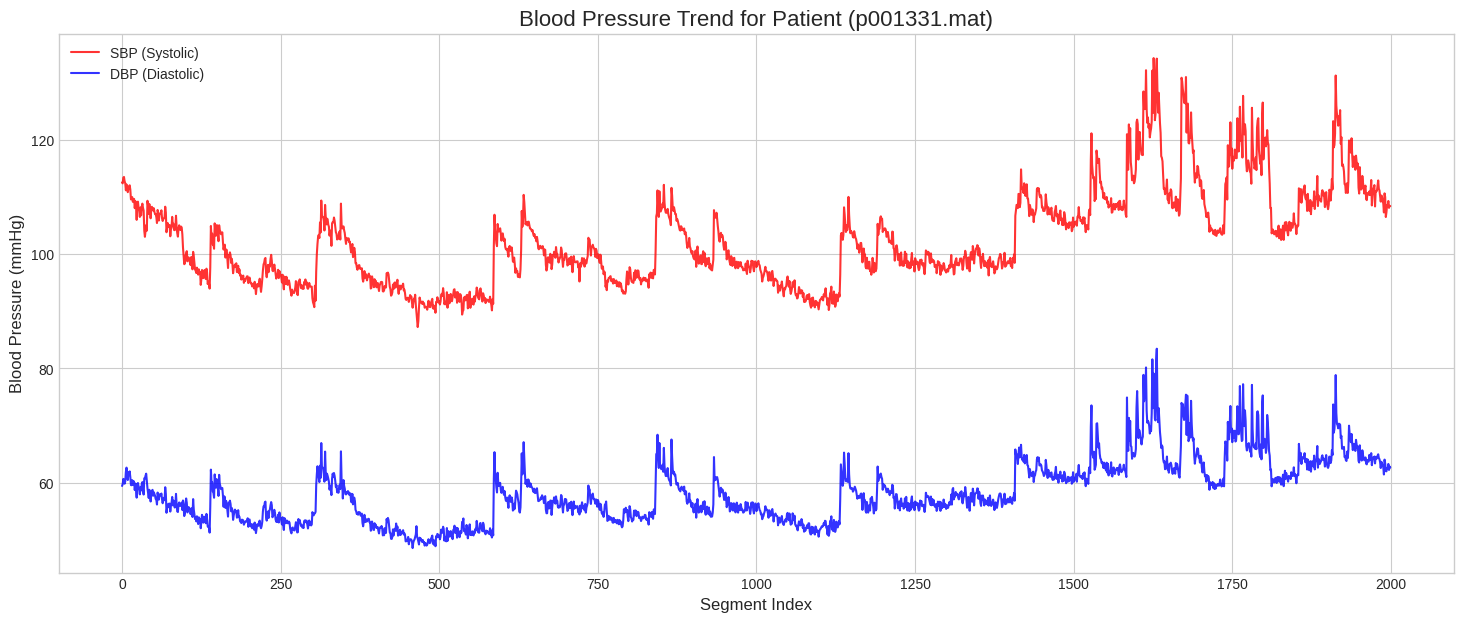


요구사항 2: 혈압 범위 적합성을 분석합니다...

--- 혈압 통계 요약 ---
  - 평균 SBP: 102.52 mmHg
  - 평균 DBP: 58.30 mmHg
  - 정상 SBP (90-130) 비율: 99.15%
  - 정상 DBP (60-80) 비율: 34.40%


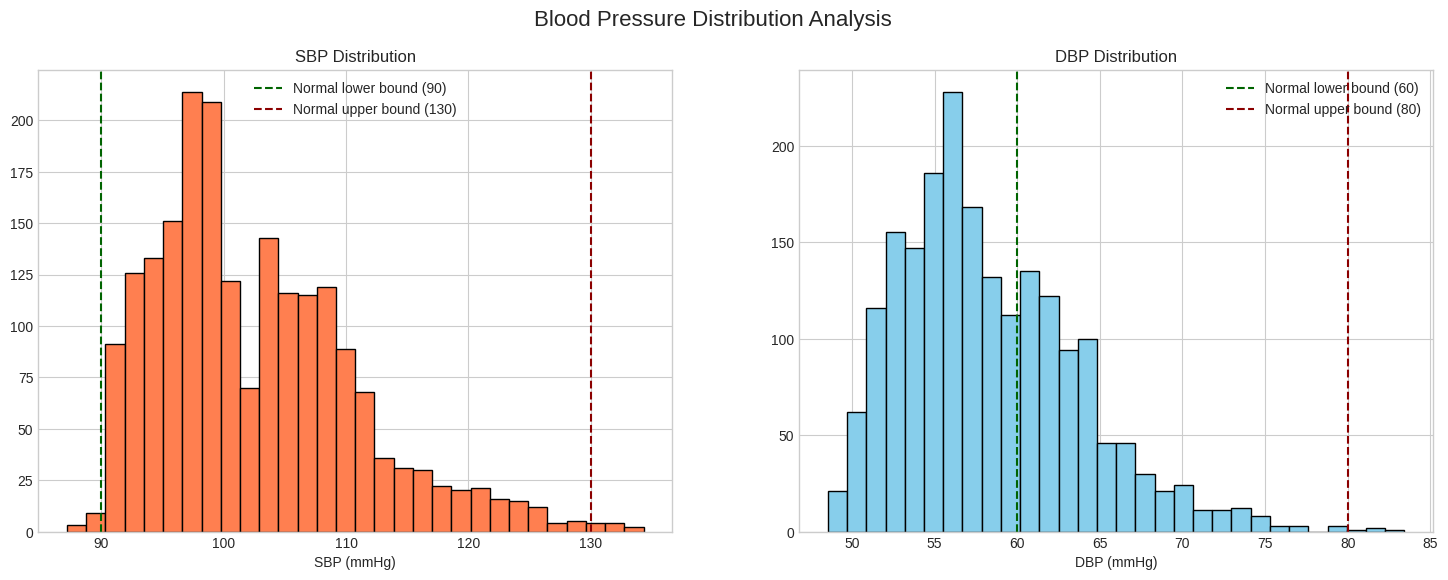


--- 최종 분석 결과 ---
❌ 이 환자는 정상 혈압 범위와 차이가 커 보입니다. 다른 환자를 찾아보는 것을 고려해 보세요.


In [6]:
# ===== 실행 부분 =====
# 1. 다운로드한 환자 .mat 파일의 전체 경로를 여기에 입력하세요.
# 예시: PATIENT_FILE_PATH = '/content/PulseDB_MIMIC/p012345.mat'
PATIENT_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/p001331.mat' # 여기에 본인의 파일 경로를 입력

# 2. 분석 함수 실행
analyze_patient_blood_pressure(PATIENT_FILE_PATH)

In [7]:
# ===================================================================
# 1. 설정 (Configuration)
# ===================================================================
# 분석할 환자 .mat 파일의 전체 경로를 지정하세요.
PATIENT_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/p001331.mat'

# 실험 모드를 선택하세요: 'PPG_ONLY' 또는 'PPG_ECG'
MODE = 'PPG_ONLY'  # 'PPG_ECG'로 변경하여 두 번째 실험 수행 가능

# ===== 추가된 기능: Bandpass 필터링 적용 여부 =====
APPLY_BANDPASS_FILTER = False # False로 변경하면 필터링 없이 실행하여 성능 비교 가능

# 하이퍼파라미터
NUM_EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
SAMPLING_RATE = 125 # 데이터셋의 샘플링 주파수 (Hz)

In [8]:
# ===================================================================
# 2. 데이터 로딩 및 전처리 함수 (수정)
# ===================================================================
def apply_bandpass_filter(signal, lowcut=0.5, highcut=8.0, fs=SAMPLING_RATE, order=4):
    """신호에 Bandpass 필터를 적용합니다."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def load_bp_data(file_path, mode='PPG_ONLY', apply_filter=False):
    """
    .mat 파일에서 분석에 필요한 데이터를 로드하고, 선택적으로 필터를 적용합니다.
    """
    print(f"'{mode}' 모드로 데이터 로딩을 시작합니다...")

    with h5py.File(file_path, 'r') as f:
        sbp_refs = f['Subj_Wins']['SegSBP'][0]
        dbp_refs = f['Subj_Wins']['SegDBP'][0]
        ppg_refs = f['Subj_Wins']['PPG_F'][0]

        # FIX: 과제 요구사항에 따라 2000개만 사용하도록 상한 설정
        num_segments = min(len(sbp_refs), 2000)

        # ===== FIX: 데이터 유효성 검사 추가 =====
        if num_segments < 2000:
            raise ValueError(
                f"오류: 환자 파일 '{os.path.basename(file_path)}'에 {num_segments}개의 세그먼트만 있습니다. "
                f"최소 2000개의 세그먼트가 필요합니다. 다른 환자를 선택해주세요."
            )

        sbps = np.array([float(f[ref][()][0, 0]) for ref in sbp_refs[:num_segments]], dtype=np.float32)
        dbps = np.array([float(f[ref][()][0, 0]) for ref in dbp_refs[:num_segments]], dtype=np.float32)
        ppgs = np.array([f[ref][()].squeeze().astype(np.float32) for ref in ppg_refs[:num_segments]])

        Y = np.vstack([sbps, dbps]).T

        if apply_filter:
            print("신호에 Bandpass 필터를 적용합니다...")
            ppgs = np.array([apply_bandpass_filter(s) for s in ppgs])

        if mode == 'PPG_ONLY':
            X = np.expand_dims(ppgs, axis=1)
        elif mode == 'PPG_ECG':
            ecg_refs = f['Subj_Wins']['ECG_F'][0]
            ecgs = np.array([f[ref][()].squeeze().astype(np.float32) for ref in ecg_refs[:num_segments]])
            if apply_filter:
                ecgs = np.array([apply_bandpass_filter(s) for s in ecgs])
            X = np.stack([ppgs, ecgs], axis=1)
        else:
            raise ValueError("Mode는 'PPG_ONLY' 또는 'PPG_ECG' 여야 합니다.")

    print(f"데이터 로딩 완료: X 형태={X.shape}, Y 형태={Y.shape}")
    return X, Y

In [9]:
# ===================================================================
# 3. 모델 정의 (Attention 메커니즘 추가) - 동일
# ===================================================================
class Attention(nn.Module):
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        self.attention_layer = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.Tanh(),
            nn.Linear(feature_dim, 1)
        )

    def forward(self, x):
        attention_weights = self.attention_layer(x)
        attention_weights = F.softmax(attention_weights, dim=1)
        context_vector = torch.sum(attention_weights * x, dim=1)
        return context_vector

class Conv1DLSTMNet(nn.Module):
    def __init__(self, input_channels=1, lstm_hidden_size=64):
        super(Conv1DLSTMNet, self).__init__()
        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.lstm = nn.LSTM(input_size=64, hidden_size=lstm_hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        self.attention = Attention(lstm_hidden_size * 2)
        self.fc_block = nn.Sequential(
            nn.Linear(lstm_hidden_size * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.cnn_extractor(x)
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        context_vector = self.attention(lstm_out)
        output = self.fc_block(context_vector)
        return output

In [10]:
# ===================================================================
# 4. 유틸리티 및 시각화 함수 (동일)
# ===================================================================
def plot_learning_curves(history, fold_num):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_num} - Learning Curves (Loss over Epochs)')
    plt.xlabel('Epoch'), plt.ylabel('MAE Loss'), plt.legend(), plt.grid(True)
    plt.show()

def plot_overall_regression_results(y_true, y_pred, patient_id):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Overall Model Performance for Patient {patient_id} (All Folds Combined)', fontsize=16)

    # SBP
    sbp_true, sbp_pred = y_true[:, 0], y_pred[:, 0]
    axes[0, 0].scatter(sbp_true, sbp_pred, alpha=0.5, c='royalblue')
    axes[0, 0].plot([min(sbp_true), max(sbp_true)], [min(sbp_true), max(sbp_true)], 'r--', label='y=x')
    axes[0, 0].set_title('SBP: Predicted vs. Actual'), axes[0, 0].set_xlabel('Actual SBP'), axes[0, 0].set_ylabel('Predicted SBP'), axes[0, 0].grid(True), axes[0, 0].legend()

    sbp_residuals = sbp_true - sbp_pred
    axes[0, 1].scatter(sbp_pred, sbp_residuals, alpha=0.5, c='coral')
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_title('SBP: Residuals vs. Predicted'), axes[0, 1].set_xlabel('Predicted SBP'), axes[0, 1].set_ylabel('Residuals'), axes[0, 1].grid(True)

    # DBP
    dbp_true, dbp_pred = y_true[:, 1], y_pred[:, 1]
    axes[1, 0].scatter(dbp_true, dbp_pred, alpha=0.5, c='mediumseagreen')
    axes[1, 0].plot([min(dbp_true), max(dbp_true)], [min(dbp_true), max(dbp_true)], 'r--', label='y=x')
    axes[1, 0].set_title('DBP: Predicted vs. Actual'), axes[1, 0].set_xlabel('Actual DBP'), axes[1, 0].set_ylabel('Predicted DBP'), axes[1, 0].grid(True), axes[1, 0].legend()

    dbp_residuals = dbp_true - dbp_pred
    axes[1, 1].scatter(dbp_pred, dbp_residuals, alpha=0.5, c='orchid')
    axes[1, 1].axhline(y=0, color='r', linestyle='--')
    axes[1, 1].set_title('DBP: Residuals vs. Predicted'), axes[1, 1].set_xlabel('Predicted DBP'), axes[1, 1].set_ylabel('Residuals'), axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Using device: cuda
'PPG_ONLY' 모드로 데이터 로딩을 시작합니다...
데이터 로딩 완료: X 형태=(2000, 1, 1250), Y 형태=(2000, 2)

===== Fold 1/5 Start =====


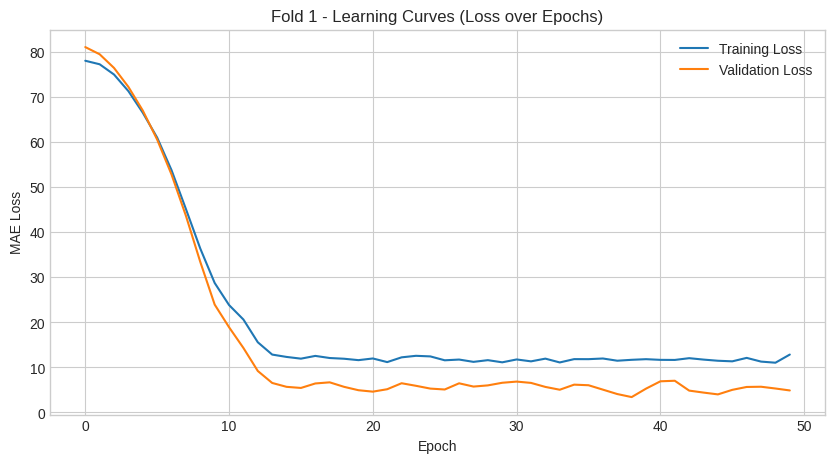

Model training completed.
Fold 1 Result -> SBP MAE: 1.92, SBP RMSE: 2.23 | DBP MAE: 1.56, DBP RMSE: 1.84

===== Fold 2/5 Start =====


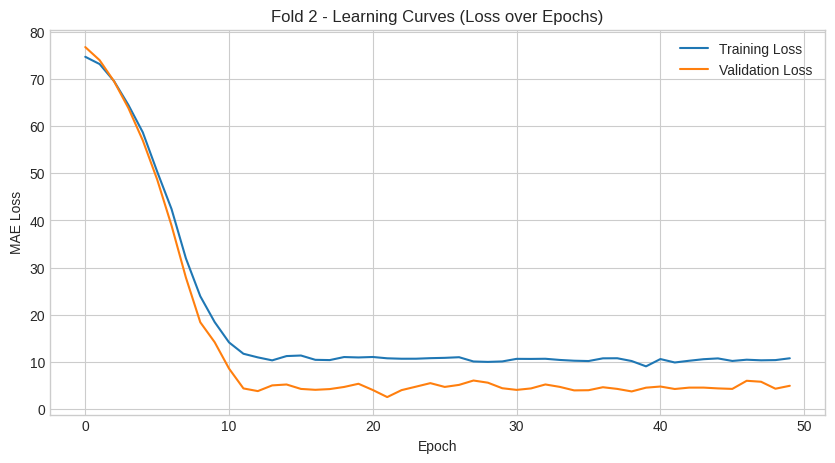

Model training completed.
Fold 2 Result -> SBP MAE: 2.03, SBP RMSE: 2.27 | DBP MAE: 1.90, DBP RMSE: 2.19

===== Fold 3/5 Start =====


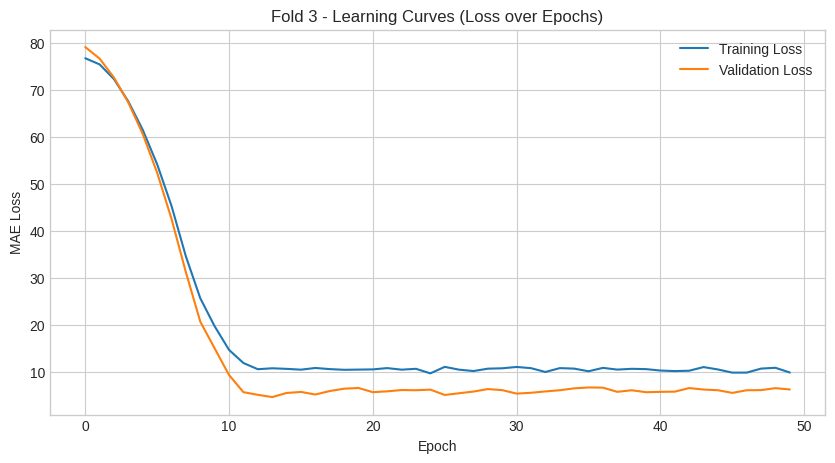

Model training completed.
Fold 3 Result -> SBP MAE: 5.84, SBP RMSE: 6.58 | DBP MAE: 3.84, DBP RMSE: 4.41

===== Fold 4/5 Start =====


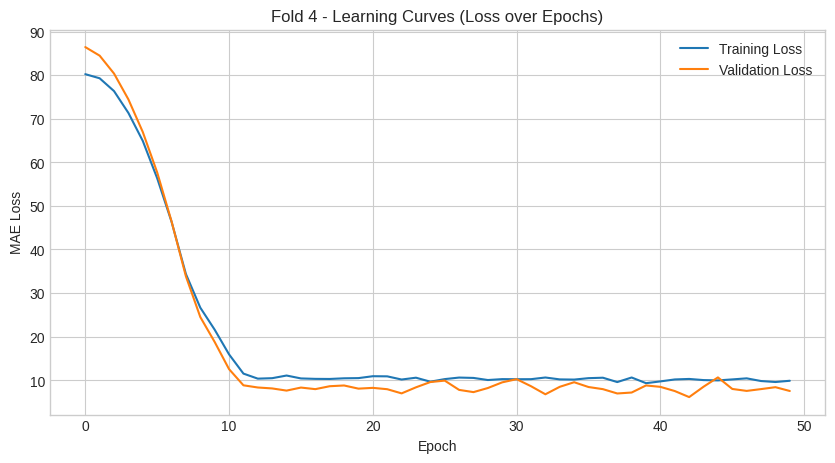

Model training completed.
Fold 4 Result -> SBP MAE: 10.99, SBP RMSE: 11.93 | DBP MAE: 6.14, DBP RMSE: 6.97

===== Fold 5/5 Start =====


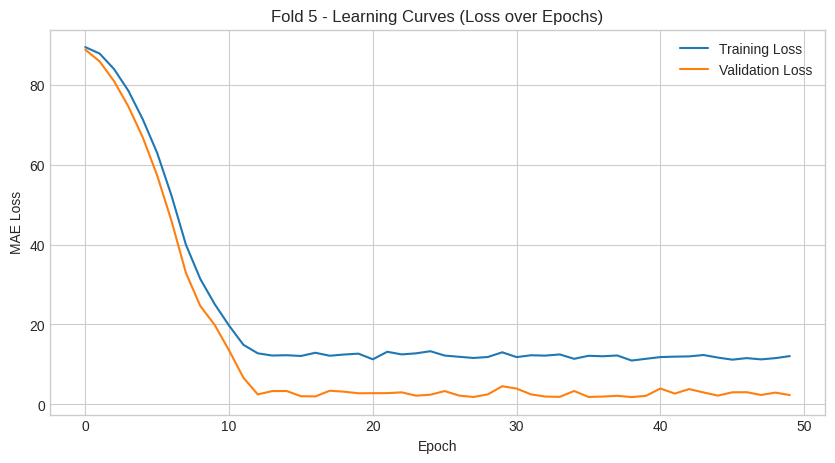

Model training completed.
Fold 5 Result -> SBP MAE: 1.25, SBP RMSE: 1.58 | DBP MAE: 0.89, DBP RMSE: 1.15


In [11]:
# ===================================================================
# 5. 메인 실행 블록 (수정)
# ===================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 데이터 로드 (파일이 없거나 세그먼트 수가 부족하면 여기서 에러 발생)
try:
    X_data, Y_data = load_bp_data(PATIENT_FILE_PATH, mode=MODE, apply_filter=APPLY_BANDPASS_FILTER)
except (FileNotFoundError, ValueError) as e:
    print(e)
    # exit() # 스크립트 실행을 중단하려면 이 줄의 주석을 해제하세요.

patient_id = os.path.basename(PATIENT_FILE_PATH).replace('.mat', '')

# 교차 검증 설정
n_splits = 5
fold_size = 400
train_size, val_size, test_size = 320, 40, 40

fold_metrics = []
all_y_true, all_y_pred = [], []

# 데이터가 성공적으로 로드되었을 경우에만 루프 실행
if 'X_data' in locals():
    for i in range(n_splits):
        print(f"\n===== Fold {i+1}/{n_splits} Start =====")

        # ===== FIX: 더 안전하고 명확한 데이터 분할 로직 =====
        fold_start = i * fold_size
        train_start, val_start, test_start = fold_start, fold_start + train_size, fold_start + train_size + val_size

        X_train, Y_train = X_data[train_start : val_start], Y_data[train_start : val_start]
        X_val, Y_val = X_data[val_start : test_start], Y_data[val_start : test_start]
        X_test, Y_test = X_data[test_start : fold_start + fold_size], Y_data[test_start : fold_start + fold_size]

        # 스케일링
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
        X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

        # DataLoader 생성
        train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_scaled).float(), torch.from_numpy(Y_train)), batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val_scaled).float(), torch.from_numpy(Y_val)), batch_size=BATCH_SIZE)

        model = Conv1DLSTMNet(input_channels=X_data.shape[1]).to(device)
        criterion, optimizer = nn.L1Loss(), torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # 모델 학습
        history = {'train_loss': [], 'val_loss': []}
        for epoch in range(NUM_EPOCHS):
            model.train()
            train_loss = 0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

            history['train_loss'].append(train_loss / len(train_loader))
            history['val_loss'].append(val_loss / len(val_loader))

        plot_learning_curves(history, fold_num=i+1)
        print("Model training completed.")

        # 모델 평가
        model.eval()
        with torch.no_grad():
            Y_pred_fold = model(torch.from_numpy(X_test_scaled).float().to(device)).cpu().numpy()

        sbp_mae = mean_absolute_error(Y_test[:, 0], Y_pred_fold[:, 0])
        sbp_rmse = np.sqrt(mean_squared_error(Y_test[:, 0], Y_pred_fold[:, 0]))
        dbp_mae = mean_absolute_error(Y_test[:, 1], Y_pred_fold[:, 1])
        dbp_rmse = np.sqrt(mean_squared_error(Y_test[:, 1], Y_pred_fold[:, 1]))

        fold_metrics.append({'sbp_mae': sbp_mae, 'sbp_rmse': sbp_rmse, 'dbp_mae': dbp_mae, 'dbp_rmse': dbp_rmse})
        all_y_true.append(Y_test)
        all_y_pred.append(Y_pred_fold)

        print(f"Fold {i+1} Result -> SBP MAE: {sbp_mae:.2f}, SBP RMSE: {sbp_rmse:.2f} | DBP MAE: {dbp_mae:.2f}, DBP RMSE: {dbp_rmse:.2f}")


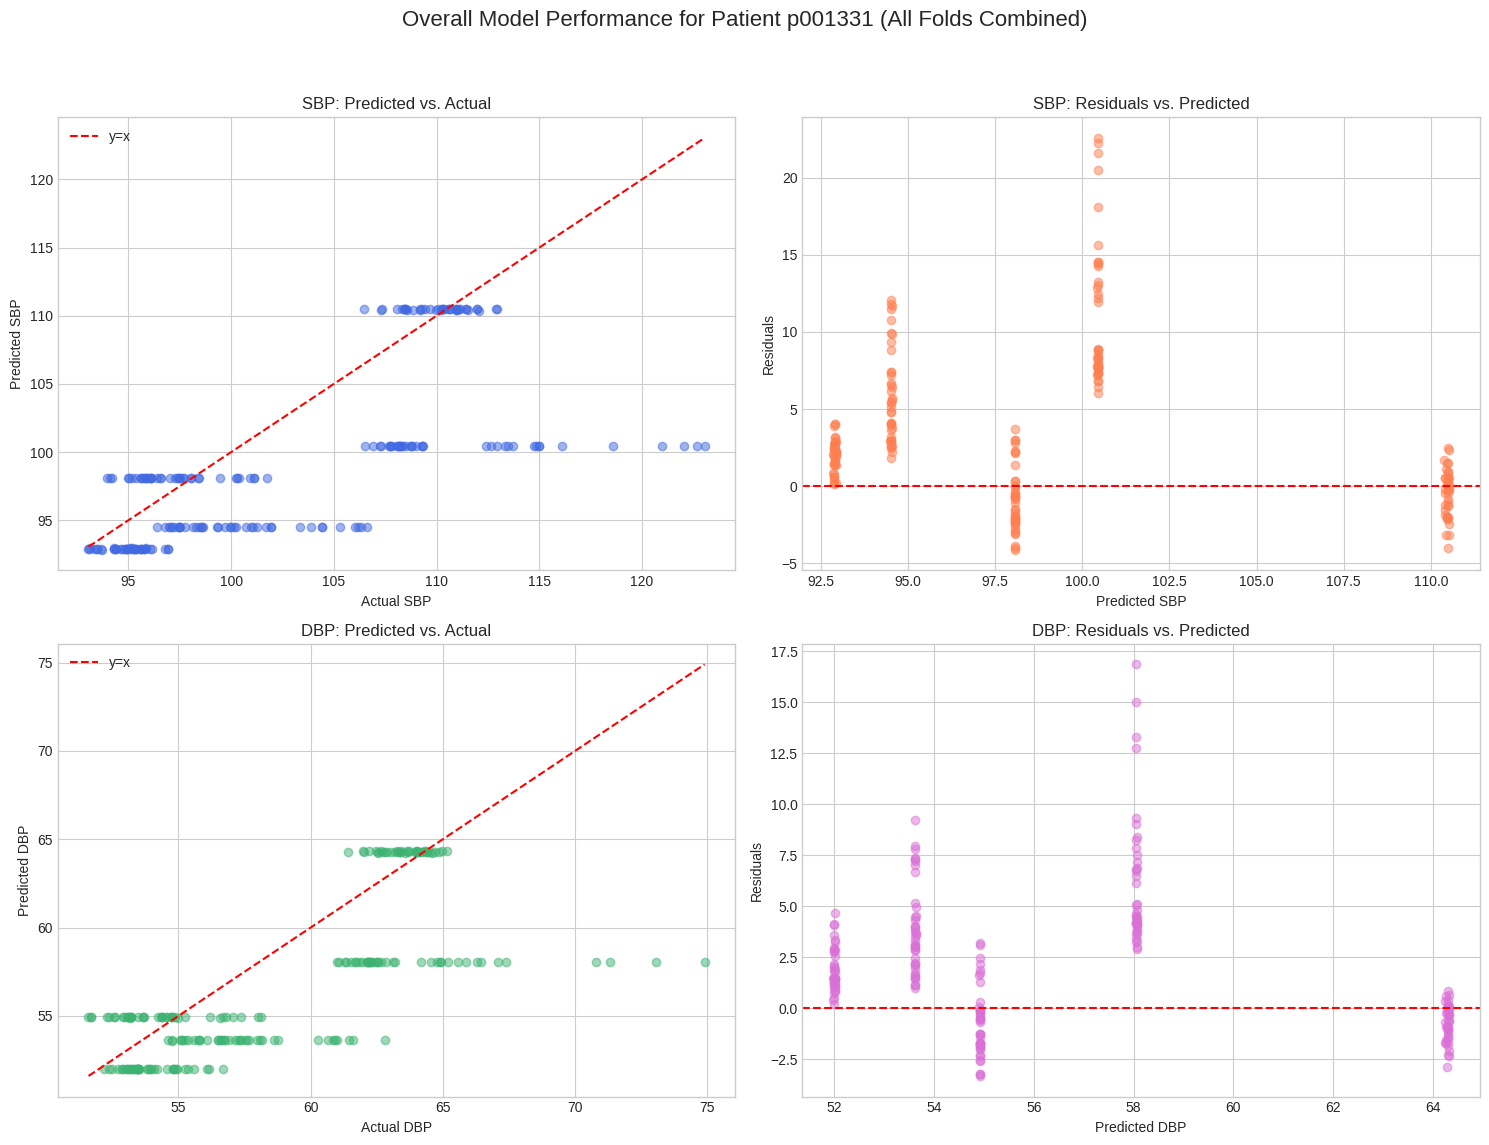


===== Final Results Summary =====
Patient ID: p001331, Mode: PPG_ONLY, Filter Applied: False

--- Fold-wise Metrics ---
Fold 1: SBP MAE=1.92, RMSE=2.23 | DBP MAE=1.56, RMSE=1.84
Fold 2: SBP MAE=2.03, RMSE=2.27 | DBP MAE=1.90, RMSE=2.19
Fold 3: SBP MAE=5.84, RMSE=6.58 | DBP MAE=3.84, RMSE=4.41
Fold 4: SBP MAE=10.99, RMSE=11.93 | DBP MAE=6.14, RMSE=6.97
Fold 5: SBP MAE=1.25, RMSE=1.58 | DBP MAE=0.89, RMSE=1.15


In [12]:
# ===================================================================
# 6. 최종 결과 요약 (동일)
# ===================================================================
final_y_true = np.concatenate(all_y_true)
final_y_pred = np.concatenate(all_y_pred)
plot_overall_regression_results(final_y_true, final_y_pred, patient_id)

print("\n===== Final Results Summary =====")
print(f"Patient ID: {patient_id}, Mode: {MODE}, Filter Applied: {APPLY_BANDPASS_FILTER}\n")
print("--- Fold-wise Metrics ---")
for i, metrics in enumerate(fold_metrics):
    print(f"Fold {i+1}: SBP MAE={metrics['sbp_mae']:.2f}, RMSE={metrics['sbp_rmse']:.2f} | "
          f"DBP MAE={metrics['dbp_mae']:.2f}, RMSE={metrics['dbp_rmse']:.2f}")

In [13]:
print("\n--- Average Metrics (5-Fold) ---")
avg_sbp_mae = np.mean([m['sbp_mae'] for m in fold_metrics])
std_sbp_mae = np.std([m['sbp_mae'] for m in fold_metrics])
avg_sbp_rmse = np.mean([m['sbp_rmse'] for m in fold_metrics])
std_sbp_rmse = np.std([m['sbp_rmse'] for m in fold_metrics])
avg_dbp_mae = np.mean([m['dbp_mae'] for m in fold_metrics])
std_dbp_mae = np.std([m['dbp_mae'] for m in fold_metrics])
avg_dbp_rmse = np.mean([m['dbp_rmse'] for m in fold_metrics])
std_dbp_rmse = np.std([m['dbp_rmse'] for m in fold_metrics])

print(f"SBP MAE : {avg_sbp_mae:.2f} ± {std_sbp_mae:.2f}")
print(f"SBP RMSE: {avg_sbp_rmse:.2f} ± {std_sbp_rmse:.2f}")
print(f"DBP MAE : {avg_dbp_mae:.2f} ± {std_dbp_mae:.2f}")
print(f"DBP RMSE: {avg_dbp_rmse:.2f} ± {std_dbp_rmse:.2f}")


--- Average Metrics (5-Fold) ---
SBP MAE : 4.40 ± 3.66
SBP RMSE: 4.92 ± 3.93
DBP MAE : 2.87 ± 1.91
DBP RMSE: 3.31 ± 2.13
